In [1]:
from typing import Optional, Callable
import math
import copy
import os

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers.predictive import PredictiveModel
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_sqm_model import TractsModelSqm
from cities.utils.data_loader import select_from_data
from chirho.observational.handlers import condition

smoke_test = "CI" in os.environ

n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))

kwargs = {
    "categorical": ["year", "census_tract"],
    "continuous": {
        "housing_units",
        "total_value",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        "segregation_original",
        "white_original",
        'parcel_mean_sqm',
        'parcel_median_sqm',
        'parcel_sqm',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

/var/folders/pq/ntbz4ft13jv662kczkzk32pr0000gn/T/ipykernel_61327/3989056904.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_dataset_read = torch.load(census_tracts_da

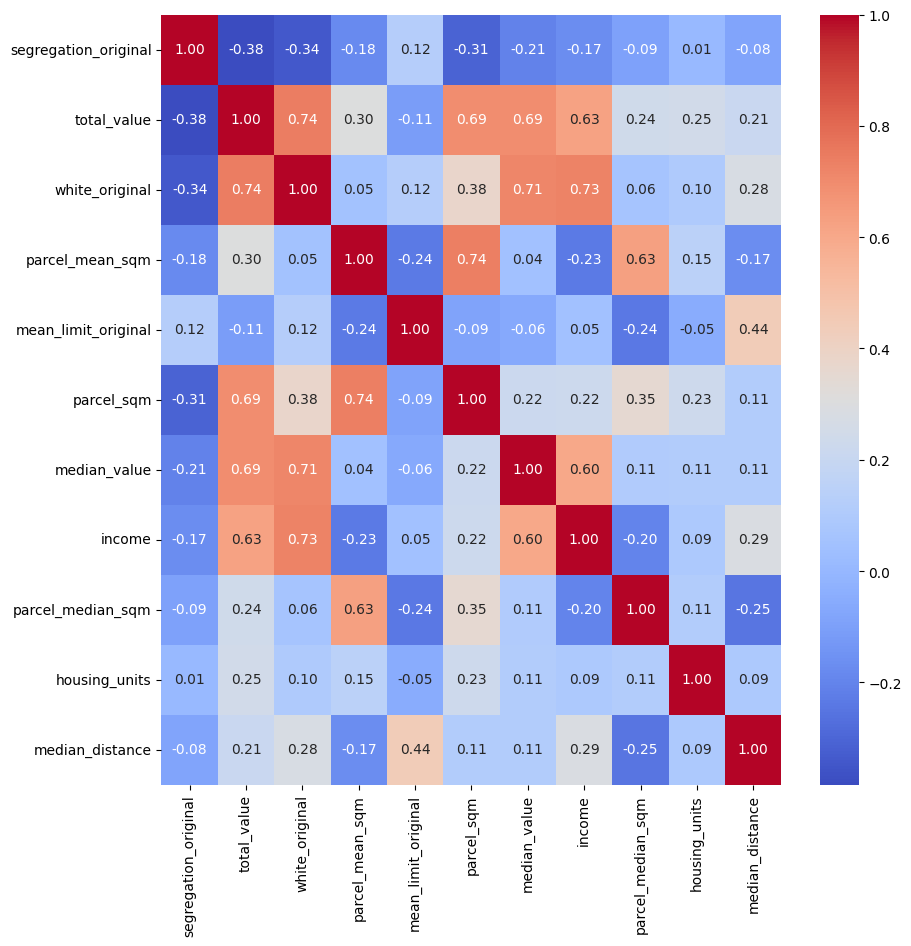

In [3]:
subset['continuous']

subset_continuous = subset['continuous']

continuous_np = {key: tensor.numpy() for key, tensor in subset_continuous.items()}
df = pd.DataFrame(continuous_np)
# columns_to_drop = ['column1', 'column2']
# df = df.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' avoids issues if the columns don't exist

columns = df.columns

vars_to_remove = ["census_tract", "year", "year_id"] + [
    var for var in columns if var.endswith("std")
]

vars = [var for var in columns if var not in vars_to_remove]
# plot spearman correlation between all vars in census[vars]
corr = df[vars].corr(method="spearman")

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
(1130,) ()
torch.Size([1130])
(1130,) ()
torch.Size([1130])
(1130,) ()
torch.Size([1130])
(1130,) ()
torch.Size([1130])


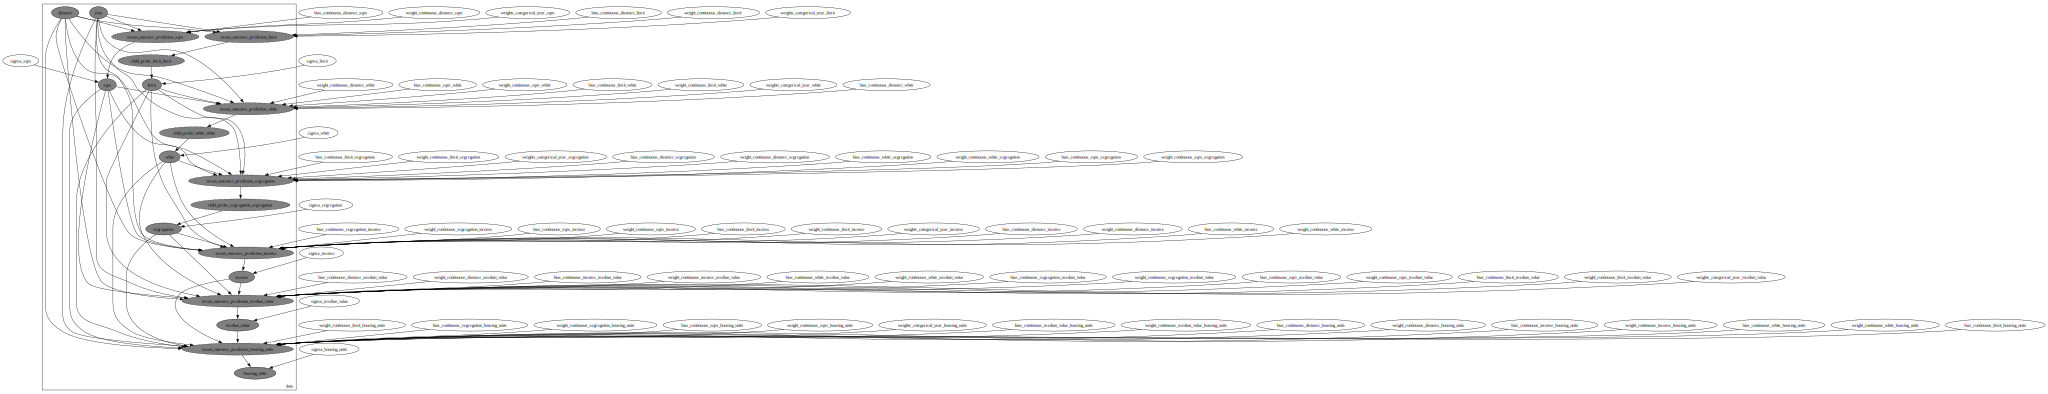

In [4]:
# instantiation and prior predictive run

tracts_model = TractsModelSqm(
    **subset, categorical_levels=ct_dataset_read.categorical_levels
)

with pyro.poutine.trace() as tr:
    tracts_model(**subset)

assert tr.trace.nodes["housing_units"]["value"].shape == torch.Size([1130])

pyro.render_model(
    lambda: tracts_model(**subset),
    render_deterministic=True,
)

In [5]:
# pyro.clear_param_store()


# train_loader, test_loader, categorical_levels = prep_data_for_test(
#     census_tracts_data_path, train_size=0.6
# )

# performance_results = test_performance(
#     tracts_model,
#     kwargs,
#     train_loader,
#     test_loader,
#     categorical_levels,
#     outcome_type="continuous",
#     outcome_name="housing_units",
#     n_steps=n_steps,
#     plot=True,
#     is_class=False,
# )

In [6]:
def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()


# mae_improvement_train = destandardize_housing_units(
#     performance_results["mae_null_train"] - performance_results["mae_train"]
# )
# mae_improvement_test = destandardize_housing_units(
#     performance_results["mae_null_test"] - performance_results["mae_test"]
# )

# print(
#     f"MAE improvements on the original scale: {mae_improvement_test, mae_improvement_train}"
# )

torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
[iteration 0001] loss: 231956.7031
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size(

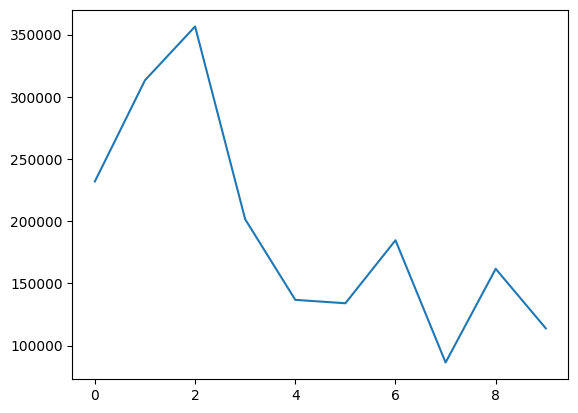

In [7]:
pyro.clear_param_store()
n_steps = 10
guide = run_svi_inference(tracts_model, n_steps=n_steps, lr=0.03, **subset)

predictive = Predictive(tracts_model, guide=guide, num_samples=num_samples)


In [8]:
if not smoke_test:
    serialized_guide = dill.dumps(guide)
    file_path = os.path.join(root, "data/minneapolis/guides", f"tracts_sqm_model_guide_pg.pkl")
    with open(file_path, "wb") as file:
        file.write(serialized_guide)

    param_path = os.path.join(
        root, "data/minneapolis/guides", "tracts_sqm_model_params_pg.pth"
    )

    pyro.get_param_store().save(param_path)

In [9]:

subset_for_preds = copy.deepcopy(subset)
vars_to_suspend = ["housing_units"] #, "white", "segregation", "income", "median_value"]

for var in vars_to_suspend:
    subset_for_preds["continuous"][var] = None


preds = predictive(**subset_for_preds)

torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130]) torch.Size([])
t

torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([1130]) torch.Size([])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([3, 1, 1, 1, 1130]) torch.Size([])
torch.Size([1130])
torch.Size([3, 1, 1, 1, 1130]) torch.Size([])
torch.Size([1130])
torch.Size([3, 1, 1, 1, 1130]) torch.Size([])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([3, 1, 1, 1, 1130]) torch.Size([])
torch.Size([1130])
torch.Size([3, 1, 1, 1, 1130]) torch.Size([])
torch.Size([1130])
torch.Size([3, 1, 1, 1, 1130]) torch.Size([])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([3, 1, 1, 1, 1130]) torch.Size([])
torch.Size([1130])
torch.Size([3, 1, 1, 1, 1130]) torch.Size([])
torch.Size([1130])
torch.Size([3, 1, 1, 1, 1130]) torch.Size([])
torch.Size([1130]) torch.Size([])
torch.Size([1130])
torch.Size([3, 1, 1, 1, 1130]) torch.Size([])
torch.Size([1130])
to

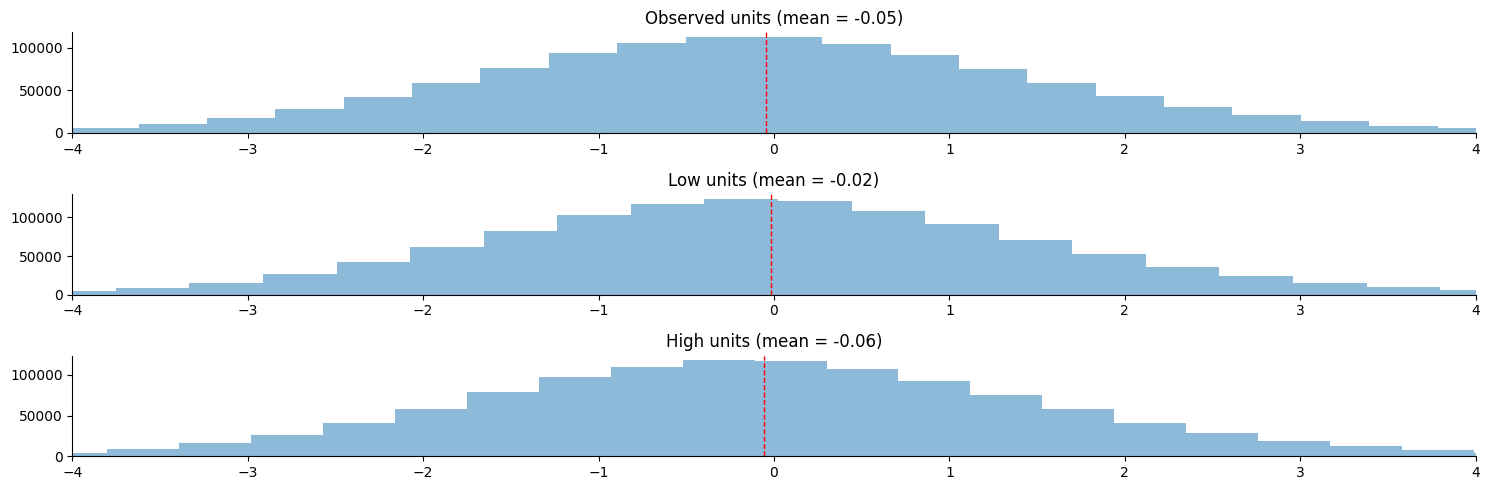

In [10]:
predictive = Predictive(tracts_model, guide=guide, num_samples=num_samples)

with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit": (torch.tensor(0.0), torch.tensor(1.0))}):
        samples = predictive(**subset_for_preds)

print(samples["limit"].shape)
print(samples["housing_units"].shape)

value = samples["limit"]
outcome = samples["housing_units"]

with mwc:
    observed_limit = gather(value, IndexSet(**{"limit": {0}}), event_dims=0)
    low_limit = gather(value, IndexSet(**{"limit": {1}}), event_dims=0)
    high_limit = gather(value, IndexSet(**{"limit": {2}}), event_dims=0)

    observed_units = gather(outcome, IndexSet(**{"limit": {0}}), event_dims=0)
    low_units = gather(outcome, IndexSet(**{"limit": {1}}), event_dims=0)
    high_units = gather(outcome, IndexSet(**{"limit": {2}}), event_dims=0)


fig, axes = plt.subplots(3, 1, figsize=(15, 5))


observed_mean = observed_units.mean()
low_mean = low_units.mean()
high_mean = high_units.mean()

print(observed_mean, low_mean, high_mean)

axes[0].hist(
    observed_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="observed"
)
axes[0].axvline(observed_mean, color="r", linestyle="dashed", linewidth=1)
axes[0].set_title(f"Observed units (mean = {observed_mean:.2f})")
axes[0].set_xlim(-4, 4)

axes[1].hist(low_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="low")
axes[1].axvline(low_mean, color="r", linestyle="dashed", linewidth=1)
axes[1].set_title(f"Low units (mean = {low_mean:.2f})")
axes[1].set_xlim(-4, 4)

axes[2].hist(high_units.flatten().detach().numpy(), bins=50, alpha=0.5, label="high")
axes[2].axvline(high_mean, color="r", linestyle="dashed", linewidth=1)
axes[2].set_title(f"High units (mean = {high_mean:.2f})")
axes[2].set_xlim(-4, 4)

plt.tight_layout()
sns.despine()
plt.show()

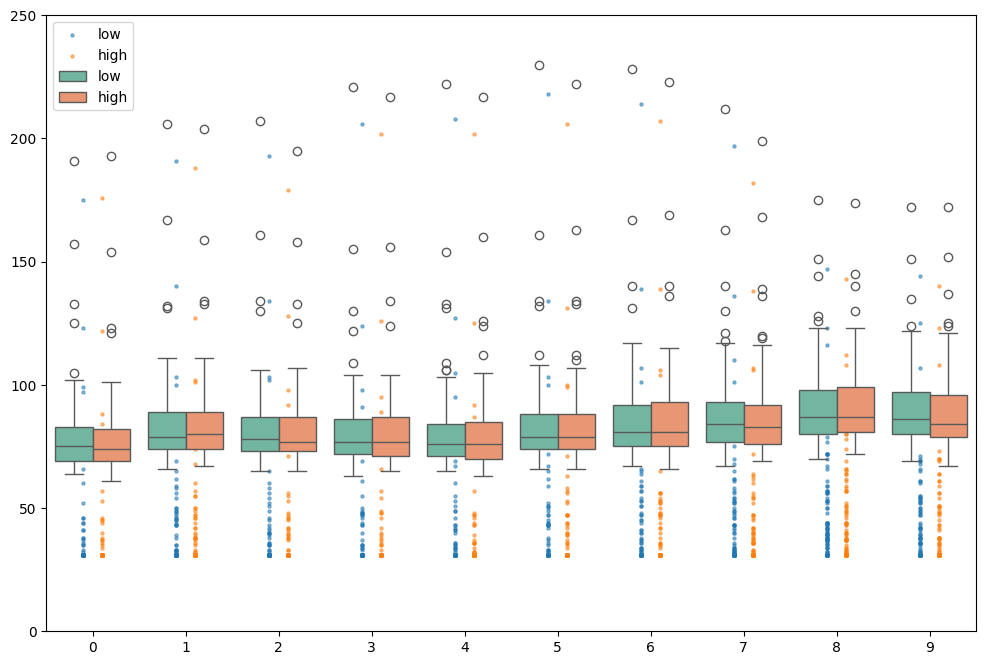

In [11]:
years = data["categorical"]["year"].flatten().detach().numpy()
years_full = years - 0.1
years_no = years + 0.1


plt.figure(figsize=(12, 8))
plt.scatter(
    x=years_full,
    y=destandardize_housing_units(low_units.mean(axis=0).clamp(min=0).flatten().detach()),
    s=5,
    alpha=0.5,
    label="low",
)


plt.scatter(
    x=years_no,
    y=destandardize_housing_units(high_units.mean(axis=0).clamp(min =0).flatten().detach()),
    s=5,
    alpha=0.5,
    label="high",
)


data_combined = np.concatenate(
    (
        destandardize_housing_units(low_units.clamp(min = 0).mean(axis=0).flatten()),
        destandardize_housing_units(high_units.clamp(min=0).mean(axis=0).flatten()),
    )
)
years_combined = np.concatenate((years, years))
labels_combined = np.concatenate(
    (np.repeat("low", len(years)), np.repeat("high", len(years)))
)


boxplot = sns.boxplot(
    x=years_combined,
    y=data_combined,
    hue=labels_combined,
    dodge=True,
    palette="Set2",
   
)

plt.ylim(0,250)
plt.legend()
plt.show()

Explainability questions:

In [104]:
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports

Data processing to condition on it

In [105]:
BATCH_SIZE=11
NSAMPLES=17

In [106]:
ct_loader_query = DataLoader(ct_dataset_read, batch_size=BATCH_SIZE, shuffle=True)
data_query = next(iter(ct_loader_query))

subset_query = select_from_data(data_query, kwargs)

subset_for_preds_query = copy.deepcopy(subset_query)
vars_to_suspend = ["housing_units"] #, "white", "segregation", "income", "median_value"]

for var in vars_to_suspend:
    subset_for_preds_query["continuous"][var] = None

In [107]:
import torch
from copy import deepcopy
from cities.modeling.model_components import get_n

def recurse_dict(d, fn):
    for k, v in d.items():
        if isinstance(v, torch.Tensor):
            d[k] = fn(v)
        elif isinstance(v, dict):
            d[k] = recurse_dict(v, fn)
    return d

def nonify_dict_(d):
    for k, v in d.items():
        if isinstance(v, torch.Tensor):
            d[k] = None
        elif isinstance(v, dict):
            d[k] = nonify_dict_(v)
    return d


def nonify_dict(d):
    d = deepcopy(d)
    return nonify_dict_(d)


SUBSET_SITE_NAME_MAP = {
    "white": "white_original",
    "segregation": "segregation_original",
    "limit": "mean_limit_original",
    "distance": "median_distance",
}


def map_subset_onto_obs(subset, site_names):
    obs = dict()

    for name in site_names:
        subset_name = SUBSET_SITE_NAME_MAP.get(name, name)
        for k, inner_subset_dict in subset.items():
            if k == "outcome":
                continue
            if subset_name in inner_subset_dict:
                obs[name] = inner_subset_dict[subset_name]
                break

    assert obs.keys() == set(site_names), f"Missing keys: {set(site_names) - obs.keys()}"
    return obs

In [108]:
predictive = PredictiveModel(tracts_model, guide=guide)

with ExtractSupports() as s:
    predictive(**subset_for_preds_query, n=BATCH_SIZE)

print(s.supports)

torch.Size([11]) torch.Size([])
torch.Size([11])
torch.Size([11]) torch.Size([])
torch.Size([11])
torch.Size([11]) torch.Size([])
torch.Size([11])
torch.Size([11]) torch.Size([])
{'_AutoMultivariateNormal_latent': IndependentConstraint(Real(), 1), 'sigma_sqm': IndependentConstraint(Real(), 0), 'bias_continuous_distance_sqm': IndependentConstraint(Real(), 0), 'weight_continuous_distance_sqm': IndependentConstraint(Real(), 0), 'weights_categorical_year_sqm': IndependentConstraint(Real(), 1), 'bias_continuous_distance_limit': IndependentConstraint(Real(), 0), 'weight_continuous_distance_limit': IndependentConstraint(Real(), 0), 'weights_categorical_year_limit': IndependentConstraint(Real(), 1), 'sigma_limit': IndependentConstraint(Real(), 0), 'bias_continuous_distance_white': IndependentConstraint(Real(), 0), 'weight_continuous_distance_white': IndependentConstraint(Real(), 0), 'bias_continuous_sqm_white': IndependentConstraint(Real(), 0), 'weight_continuous_sqm_white': IndependentConstra

In [197]:
DIM = -10
broadcast_data_over_samples = lambda t: t.expand((NSAMPLES, *((1,)*(abs(DIM)-2)), t.shape[-1]))
subset_broadcast = copy.deepcopy(subset_for_preds_query)
recurse_dict(subset_broadcast, broadcast_data_over_samples)

subset_none = nonify_dict(subset_for_preds_query)
# print_shapes = lambda t: print(t.shape)
# recurse_dict(subset_broadcast, print_shapes)
# # recurse_dict(subset_for_preds_query, print_shapes)

In [211]:
with MultiWorldCounterfactual(first_available_dim=-2) as mwc:
    with SearchForExplanation(
        supports=s.supports,
        # antecedents={"limit": torch.tensor(1.0), "income": torch.tensor(1.0)},
        antecedents = {"distance": None, "sqm": None, "limit": None, "white": None, "segregation": None, "median_value": None, "income":None},
        consequents={"housing_units": torch.tensor(1.0)},
        witnesses={}, # potential context elements, we leave them empty for now
        # alternatives = {"income": torch.tensor(0.0), "segregation": torch.tensor(0.0)},
        antecedent_bias=-0.5,
        consequent_scale=1e-5,
    ):
        with pyro.plate("samples", size=NSAMPLES, dim=DIM):
            with pyro.poutine.trace() as tr_conditioned:
                # 
                predictive(**subset_broadcast, n=BATCH_SIZE)

__cause____antecedent_distance
torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 3, 11]) torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 11])
__cause____antecedent_sqm
__cause____antecedent_limit
__cause____antecedent_white
__cause____antecedent_segregation
torch.Size([17, 1, 1, 1, 3, 3, 3, 3, 3, 11]) torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 11])
__cause____antecedent_income
torch.Size([17, 1, 1, 3, 3, 3, 3, 3, 3, 11]) torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 11])
__cause____antecedent_median_value
torch.Size([17, 1, 3, 3, 3, 3, 3, 3, 3, 11]) torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [149]:
tr_conditioned.trace.compute_log_prob()

In [150]:
tr_conditioned.trace.nodes['__cause____consequent_housing_units']

KeyError: '__cause____consequent_housing_units'

In [207]:
query = SearchForExplanation(
        supports=s.supports,
        # antecedents={"limit": torch.tensor(1.0), "income": torch.tensor(1.0)},
        antecedents = {"income": None, "distance": None, "sqm": None, "limit": None, "white":None, "segregation": None, "median_value":None},
        consequents={"housing_units": torch.tensor(1.0)},
        # witnesses={}, # potential context elements, we leave them empty for now
        # alternatives = {"income": torch.tensor(0.0), "segregation": torch.tensor(0.0)},
        witnesses={"income": None, "distance": None, "sqm": None, "limit": None, "white": None, "segregation": None, "median_value": None},
        antecedent_bias=-0.5,
        consequent_scale=1,
    )(predictive)

In [208]:
def importance_infer(
    model: Optional[Callable] = None, *, num_samples: int
):
    
    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(
        *args,
        **kwargs
    ):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = abs(DIM)-1 # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual(first_available_dim=-2) as mwc:
            log_weights, importance_tr, _ = pyro.infer.importance.vectorized_importance_weights(
                model,
                guide,
                *args,
                num_samples=num_samples,
                max_plate_nesting=max_plate_nesting,
                normalized=False,
                **kwargs
            )

        return torch.logsumexp(log_weights, dim=0), importance_tr, mwc, log_weights

    return _wrapped_model

In [209]:
logp, trace, mwc, log_weights = importance_infer(num_samples=NSAMPLES)(query)(**subset_broadcast, n=BATCH_SIZE)


__cause____antecedent_distance
__cause____witness_distance
torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 3, 11]) torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 11])
__cause____antecedent_sqm
__cause____witness_sqm
__cause____antecedent_limit
__cause____witness_limit
__cause____antecedent_white
__cause____witness_white
__cause____antecedent_segregation
__cause____witness_segregation
torch.Size([17, 1, 1, 1, 3, 3, 3, 3, 3, 11]) torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 11])
__cause____antecedent_income
__cause____witness_income
torch.Size([17, 1, 1, 3, 3, 3, 3, 3, 3, 11]) torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 11])
__cause____antecedent_median_value
__cause____witness_median_value
torch.Size([17, 1, 3, 3, 3, 3, 3, 3, 3, 11]) torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 1, 1])
__cause____antecedent_distance
__cause____witness_distance
torch.Size([17, 1, 1, 1, 1, 1, 1, 1, 3, 11]) torc

/Users/Admin/Desktop/basis/pyro/pyro/util.py:284: UserWarning: Found auxiliary vars in the model: {'_AutoMultivariateNormal_latent'}
  warnings.warn(


In [210]:
trace.nodes['__cause____consequent_housing_units']['log_prob'].shape

torch.Size([17, 1, 3, 3, 3, 3, 3, 3, 3, 11])

In [164]:
mask_intervened = trace.nodes["__cause____witness_income"]["value"] == 0
print(torch.sum(torch.exp(log_weights - logp) * mask_intervened.squeeze()))

RuntimeError: The size of tensor a (17) must match the size of tensor b (11) at non-singleton dimension 1

In [51]:
from chirho.indexed.ops import indices_of
for i in tr_conditioned.trace.nodes.keys():
    if i.startswith('__cause__'):
        print(i)
probs = tr_conditioned.trace.compute_log_prob()
print(tr_conditioned.trace.nodes.keys())
print(probs)

print(len(subset_for_preds['categorical']['year']))

print(tr_conditioned.trace.nodes['housing_units']['value'].shape)


# with mwc:
#     print(gather(tr_conditioned.trace.nodes['year']['value'], IndexSet(**{"limit": {0}})))
#     print(gather(tr_conditioned.trace.nodes['income']['value'], IndexSet(**{"limit": {0}}))[:, :, :, :, 0])
#     print(gather(tr_conditioned.trace.nodes['income']['value'], IndexSet(**{"limit": {1}})))
#     print(gather(tr_conditioned.trace.nodes['income']['value'], IndexSet(**{"limit": {2}})))
    

log_probs = tr_conditioned.trace.nodes['__cause____consequent_housing_units_low']['log_prob'].sum(dim=[0])
print(log_probs.shape)
Z = torch.logsumexp(log_probs.flatten(), dim=-1)
probs = torch.exp(log_probs - Z)
print(probs.shape)


__cause___alternative_housing_units
__cause____antecedent_housing_units
__cause____consequent_housing_units_low
odict_keys(['samples', 'AutoMultivariateNormal.scale', 'AutoMultivariateNormal.scale_tril', 'AutoMultivariateNormal.loc', '_AutoMultivariateNormal_latent', 'sigma_sqm', 'bias_continuous_distance_sqm', 'weight_continuous_distance_sqm', 'weights_categorical_year_sqm', 'bias_continuous_distance_limit', 'weight_continuous_distance_limit', 'weights_categorical_year_limit', 'sigma_limit', 'bias_continuous_distance_white', 'weight_continuous_distance_white', 'bias_continuous_sqm_white', 'weight_continuous_sqm_white', 'bias_continuous_limit_white', 'weight_continuous_limit_white', 'weights_categorical_year_white', 'sigma_white', 'bias_continuous_distance_segregation', 'weight_continuous_distance_segregation', 'bias_continuous_white_segregation', 'weight_continuous_white_segregation', 'bias_continuous_sqm_segregation', 'weight_continuous_sqm_segregation', 'bias_continuous_limit_segreg

In [122]:
a = PredictiveModel(tracts_model, guide=guide)
# with pyro.poutine.trace() as tr_conditioned:

with pyro.plate("samples", size=NSAMPLES, dim=-3):
    with MultiWorldCounterfactual() as mwc:
        with SearchForExplanation(
            supports=s.supports,
            # antecedents={"limit": torch.tensor(1.0), "income": torch.tensor(1.0)},
            antecedents = {"income": torch.tensor(-0.5)},
            consequents={"housing_units": torch.tensor(1.0)},
            witnesses={}, # potential context elements, we leave them empty for now
            # alternatives={"limit": torch.tensor(0.0)},
            antecedent_bias=-0.5,
            consequent_scale=1e-5,
        ):
            a.forward(**subset_broadcast, n=BATCH_SIZE)


torch.Size([10, 1, 7]) torch.Size([10, 1, 1])
torch.Size([10, 1, 7])
torch.Size([10, 1, 7]) torch.Size([10, 1, 1])
torch.Size([10, 1, 7])
__cause____antecedent_income
torch.Size([3, 1, 10, 1, 7]) torch.Size([10, 1, 1])
torch.Size([10, 1, 7])
torch.Size([3, 1, 10, 1, 7]) torch.Size([10, 1, 1])


In [ ]:
predictive = Predictive(tracts_model, guide=guide, num_samples=10)

with ExtractSupports() as s:
    predictive(**subset_for_preds_query)

print(s.supports)
with MultiWorldCounterfactual() as mwc:
    with SearchForExplanation(
        supports=s.supports,
        antecedents = {"income": torch.tensor(-0.5)},
        consequents={"housing_units": torch.tensor(1.0)},
        witnesses={}, # potential context elements, we leave them empty for now
        antecedent_bias=-0.5,
        consequent_scale=1e-5,
    ):
        with pyro.poutine.trace() as tr_conditioned:
            samples = predictive(**subset_for_preds_query)